# Real Time Emotion classification using cnn and transfer learning :

**Dataset is generated using open cv in jupyter, consisting of five classes each train and test**

# Environment Check :

In [ ]:
!python --version

Python 3.11.13


In [ ]:
print("Torch:", torch.__version__)

Torch: 2.6.0+cu124


# Import Libraries :

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Setting Device :

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Device: cuda


# Accessing to paths :

In [ ]:
#Training and testing images generated through live webcam are present in folllowing folders
train_dir = "/content/drive/MyDrive/CNN Final Project/Train_Val_Images"
test_dir = "/content/drive/MyDrive/CNN Final Project/Test_Images_Emotion"

# Data Augmentation/Preprocessing using transforms:

In [ ]:
num_classes = 5
batch_size = 32
image_size = 224
num_epochs = 20

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

* Transform (from torchvision.transforms) is used to preprocess and augment images before feeding them into a neural network.
* Resizes the input images to fixed size to ensure same shape
* Flipping the image horizontally to learn symmetry by model
* Random rotation helps the model to become invariant to slight rotations
* Randomly changing the brightness and contrast of the image to simulate different lightining conditions.
* Transforms to tensor ensures converting numpy image(h*w*c) to pytorch tensor shape(c*h*w) and also scales pixel values to 0-1 normalisation i.e., x-mue/standard deviation
* To match the input distribution with model distribution using normalise
* Interpolation is used to compute the new pixel values that didn't exist in origial image



In [ ]:
train_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# Datasets and Dataloader for batches:

In [ ]:

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['Angry', 'Sad', 'Sleep', 'Smile', 'Surprise']


* Training and testing dataset is prepared using datasets by giving appropriate paths and applying respective transforms on the images present in respective folders
* Dataloader is used to create batches among training and testing datasets and to run parallely
* Shuffle =True is used to rearrange the inputs on training randomly so that memorizing is prevented

# Transfer Learning using ResNet18:

In [ ]:
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final FC layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [ ]:
model = model.to(device)

**Loss Function and optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

* Using the pretrained Resnet model , freezing all previous layers, which means not updating the weights, nor computing gradients during back propagation
* Unfreezing all layers means updating pretrained model weights too, giving full training in transfer learning
* param.requires_grad = False , not updating weights[Freezed]
* Fine tuning means unfreezing few layers of pretrained model
* Updating classification head with required input features,activation function
* model.fc.in_features fetches the input size of original fully connected dense layer
* Adding a small ANN of 1 hidden layer with 256 units and preventing overfitting with dropout
* Outputting logits for num_classes
* Adam is Adaptive Moment Estimation that Combines ideas from SGD,momentum  and RMSProp
* Automatically adjusts learning rates per parameter
* Adam optimizer to update only the parameters of model.fc, i.e., custom classifier head.
* Only optimizing classification head as freezed the pretrained model

# Train the model :

In [ ]:
#changing runtime to GPU here and rerunning all cells

def train_model(model, criterion, optimizer, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels) #y_pred and y_act
            loss.backward()  #back propagation
            optimizer.step()  #updating computed weights

            running_loss += loss.item() * inputs.size(0)  #avg loss value per sample in batch * number of samples in batch giving total loss per batch and accumulating iton all batches of 1 epoch=avg loss of 1 epoch
            _, preds = torch.max(outputs, 1)   # outputs : logits from model, finds class with highest score per sample
            correct_preds += torch.sum(preds == labels.data) #number of predictions correct in current batch and their addition

        epoch_loss = running_loss / len(train_dataset)   # total loss of all batches/number of samples in train data giving epoch loss
        epoch_acc = correct_preds.double() / len(train_dataset)
        train_losses.append(epoch_loss)

        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f"\nBest Training Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)  #replacing cuurent parameters with saved best parameters(weights and bias)
    return model



* Current model weight are copied using state dict that stores weights and biases in dictionary form
* Deep copy : Future changes won't affect the current data
* Model is setting in training mode so that gradients can be computed
* optimizer.zero_grad() : to clear old gradients for creating space

In [ ]:
model = train_model(model, criterion, optimizer, num_epochs)


Epoch 1/20
Loss: 0.2966, Accuracy: 0.8873

Epoch 2/20
Loss: 0.3456, Accuracy: 0.8734

Epoch 3/20
Loss: 0.3198, Accuracy: 0.8840

Epoch 4/20
Loss: 0.3077, Accuracy: 0.8840

Epoch 5/20
Loss: 0.3016, Accuracy: 0.8931

Epoch 6/20
Loss: 0.2893, Accuracy: 0.8915

Epoch 7/20
Loss: 0.3215, Accuracy: 0.8820

Epoch 8/20
Loss: 0.2852, Accuracy: 0.8955

Epoch 9/20
Loss: 0.2789, Accuracy: 0.8988

Epoch 10/20
Loss: 0.2928, Accuracy: 0.8862

Epoch 11/20
Loss: 0.2877, Accuracy: 0.8922

Epoch 12/20
Loss: 0.2679, Accuracy: 0.9042

Epoch 13/20
Loss: 0.2743, Accuracy: 0.9011

Epoch 14/20
Loss: 0.2876, Accuracy: 0.8958

Epoch 15/20
Loss: 0.2503, Accuracy: 0.9048

Epoch 16/20
Loss: 0.2690, Accuracy: 0.9008

Epoch 17/20
Loss: 0.2478, Accuracy: 0.9104

Epoch 18/20
Loss: 0.2591, Accuracy: 0.9017

Epoch 19/20
Loss: 0.2622, Accuracy: 0.9055

Epoch 20/20
Loss: 0.2779, Accuracy: 0.8953

Best Training Accuracy: 0.9104


# Evaluate on Test Data :

In [ ]:
model.eval()    #No weight updates, no back propagation on test data
all_preds = []
all_labels = []

with torch.no_grad():    #no gradients should compute
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   #moving predicted tensors to cpu and converting to numpy array for metrics computation
        all_labels.extend(labels.cpu().numpy())


# Metrics :

In [ ]:
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.93      0.85      0.89       102
         Sad       0.92      0.96      0.94       102
       Sleep       0.98      1.00      0.99        94
       Smile       0.91      0.95      0.93       102
    Surprise       0.98      0.94      0.96       102

    accuracy                           0.94       502
   macro avg       0.94      0.94      0.94       502
weighted avg       0.94      0.94      0.94       502



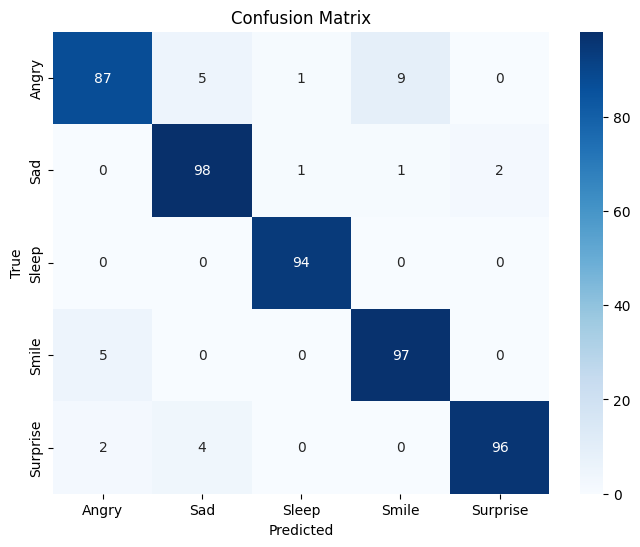

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# save the model :

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/emotion_model.pth')

In [ ]:
#to load later
#Optional: Load Model Later

# Rebuild the model and load saved weights
'''model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
model.load_state_dict(torch.load('/content/drive/MyDrive/emotion_model.pth'))
model = model.to(device)
model.eval()'''

"model = models.resnet18(pretrained=False)\nmodel.fc = nn.Sequential(\n    nn.Linear(model.fc.in_features, 256),\n    nn.ReLU(),\n    nn.Dropout(0.4),\n    nn.Linear(256, num_classes)\n)\nmodel.load_state_dict(torch.load('/content/drive/MyDrive/emotion_model.pth'))\nmodel = model.to(device)\nmodel.eval()"

# Overall Interpretation:

* Training accuracy using ResNet18 pretrained model along with ReLu activation function is 91.04%
* Test Accuracy is 94%
* Sleep and Surprise class have best precision, whereas recall is 1.00 for sleep class
* F1-score is computed best for sleep followed by surprise and sad
* 93% of predicted Angry were correct (Precision) and 85% of true Angry were found (Recall) whereas,F1 balances the two as 89%
* Average of all classes, treating each class equally with 94% macro average

**Inference is computed in corresponding jupyter notebook on loading the best saved model using pytorch**